# IMPORTS

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from utils import *
from models.UNet import UNet
from models.RUNet import RUNet
from tqdm import tqdm

import numpy as np
import seaborn as sns

In [2]:
MODEL_NAME="UNET_PERCEPTUAL_LOSS"
EPOCHS = 50
LR = 0.001
UPSCALE = 2
CROP_SIZE = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = UNet().to(DEVICE)
DEVICE

'cuda'

In [3]:
train_data = MineDataset("./datasets/comics_train",UPSCALE,CROP_SIZE,"train")
valid_data = MineDataset("./datasets/comics_valid",UPSCALE,1024,"valid")

train_loader = DataLoader(train_data, batch_size=16, num_workers=4, shuffle=True,pin_memory=True)
valid_loader = DataLoader(valid_data, batch_size=1, num_workers=4, shuffle=False,pin_memory=True)

Memory test

In [ ]:
input_tensor = torch.rand(16,1,128,128).to(DEVICE)
output_tensor = model(input_tensor)
print(output_tensor.size())

Training

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LR)
# loss_function = nn.MSELoss()
loss_function = PerceptualLoss().to(DEVICE)

trainLoss = []
# bestLoss = 10
model.train()
for epoch in tqdm(range(EPOCHS)):
    running_loss = 0.0
    
    for lr_image, hr_image in train_loader:
        lr_imgs = lr_imgs.to(DEVICE) 
        hr_imgs = hr_imgs.to(DEVICE)



        outputs = model(lr_image)
        loss = loss_function(outputs, hr_image)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        torch.save({'epoch': epoch,
                    'model': model,
                    'optimizer': optimizer},
                    './savedModels/{MODEL_NAME}.pth.tar')
        
    save_image(lr_image,f"./outputs/{epoch}_lr.jpg")
    save_image(hr_image,f"./outputs/{epoch}_hr.jpg")
    save_image(outputs,f"./outputs/{epoch}_out.jpg")
    trainLoss.append(running_loss/train_loader.batch_size)


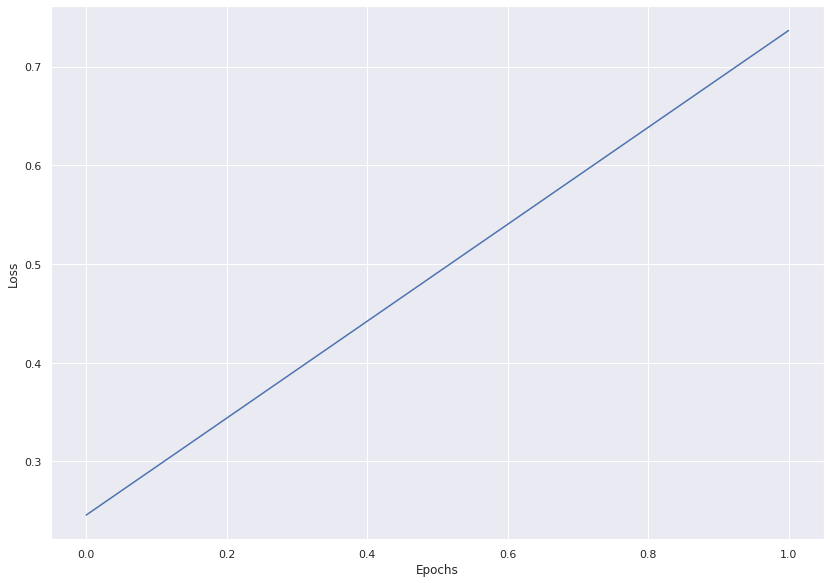

In [16]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
p = sns.lineplot(data=np.random.rand(2))
p.set_xlabel("Epochs")
p.set_ylabel("Loss")
fig = p.get_figure()
fig.tight_layout()
fig.savefig("out.png") 

Valid model

In [4]:
validLoss = []
model_psnr = []
model_ssim = []
model.load_state_dict(torch.load("./savedModels/UNET2.pth"))
model.eval()
with torch.no_grad():
        for lr_image, hr_image in tqdm(valid_loader):
            lr_image = lr_image.to(DEVICE)
            hr_image = hr_image.to(DEVICE)
          
            outputs = model(lr_image)
            
            model_psnr.append(psnr(hr_image, outputs,1.0))
            model_ssim.append(ssim(hr_image, outputs,1.0))
        
            save_image(lr_image,f"1_lr.jpg")
            save_image(hr_image,f"2_hr.jpg")
            save_image(outputs,f"3_out.jpg")

model_psnr = np.array(model_psnr)
model_ssim = np.array(model_ssim)

print(f"PSNR - {np.average(model_psnr):.3f}")
print(f"SSIM - {np.average(model_ssim):.3f}")

100%|██████████| 121/121 [01:16<00:00,  1.58it/s]

PSNR - 20.400
SSIM - 0.575


### RUNET PERCEPTUAL
PSNR - 24.731<br>
SSIM - 0.772
### UNET PERCEPTUAL
PSNR - 24.759<br>
SSIM - 0.787